In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np#TableSize,ProbingStrategy,HashFunction,KeyDistribution,LoadFactor,ProbeCount


df = pd.read_csv('../data/hash_table_stats.csv',
                 dtype={'TableSize': 'category', 'HashFunction': 'category', 'ProbingStrategy': 'category', 'KeyDistribution': 'category'})

# Delete all rows where KeyDistribution = sequential
df = df[df['KeyDistribution'] != 'Sequential']

# Reset index after filtering
df = df.reset_index(drop=True)

df.head()

,TableSize,ProbingStrategy,HashFunction,KeyDistribution,LoadFactor,ProbeCount
0,16001,LinearProbing,SimpleModuloHash,Uniform,0.000,1
1,16001,LinearProbing,SimpleModuloHash,Uniform,0.006,1
2,16001,LinearProbing,SimpleModuloHash,Uniform,0.012,1
3,16001,LinearProbing,SimpleModuloHash,Uniform,0.019,1
4,16001,LinearProbing,SimpleModuloHash,Uniform,0.025,1


Found 60 unique combinations:
Plot 1: LinearProbing + SimpleModuloHash + Uniform
Data points: 241925
Load factor range: 0.000 - 99.994
Quartile Analysis:
  Q1 (0-24.998): Avg Probe Count = 1.16 (60485 points)
  Q2 (24.998-49.997): Avg Probe Count = 1.83 (60480 points)
  Q3 (49.997-74.995): Avg Probe Count = 4.46 (60480 points)
  Q4 (74.995-99.994): Avg Probe Count = 297.15 (60480 points)
------------------------------------------------------------
Plot 2: QuadraticProbing + SimpleModuloHash + Uniform
Data points: 241910
Load factor range: 0.000 - 99.994
Quartile Analysis:
  Q1 (0-24.994): Avg Probe Count = 1.16 (60480 points)
  Q2 (24.994-49.994): Avg Probe Count = 1.71 (60480 points)
  Q3 (49.994-74.994): Avg Probe Count = 3.13 (60480 points)
  Q4 (74.994-99.994): Avg Probe Count = 31.81 (60470 points)
------------------------------------------------------------
Plot 3: DoubleHashing + SimpleModuloHash/DivisionHash + Uniform
Data points: 229919
Load factor range: 0.000 - 99.994
Quarti

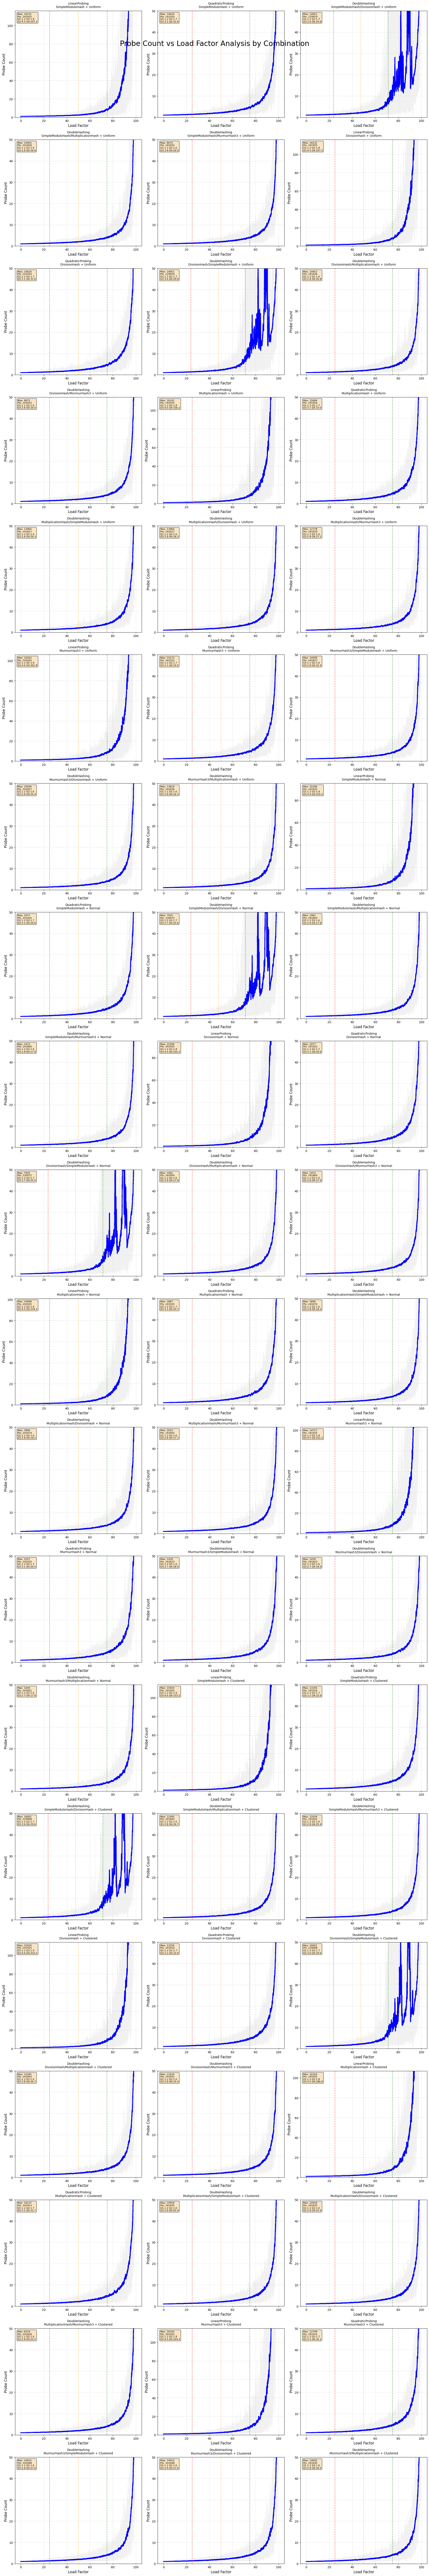

In [37]:
# Create combinations of Strategy, HashFunction, and KeyDistribution
combinations = df[['ProbingStrategy', 'HashFunction', 'KeyDistribution']].drop_duplicates()

print(f"Found {len(combinations)} unique combinations:")

# Calculate grid dimensions for subplots
n_combinations = len(combinations)
n_cols = 3  # You can adjust this based on your preference
n_rows = (n_combinations + n_cols - 1) // n_cols  # Ceiling division

# Create a large figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
fig.suptitle('Probe Count vs Load Factor Analysis by Combination', fontsize=24, y=0.98)

# Flatten axes array for easier indexing
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

# Plot each combination separately with smoothing and quartile analysis
for i, (_, combo) in enumerate(combinations.iterrows()):
    strategy = combo['ProbingStrategy']
    hash_func = combo['HashFunction']
    key_dist = combo['KeyDistribution']
    
    # Filter data for this specific combination
    combo_data = df[
        (df['ProbingStrategy'] == strategy) & 
        (df['HashFunction'] == hash_func) & 
        (df['KeyDistribution'] == key_dist)
    ].copy()
    
    if len(combo_data) > 0:
        # Use the i-th subplot
        ax = axes[i]
        
        # Sort by LoadFactor for proper line plotting
        combo_data = combo_data.sort_values('LoadFactor')
        
        # Calculate quartiles of load factor
        load_factor_quartiles = combo_data['LoadFactor'].quantile([0.25, 0.5, 0.75])
        q1, q2, q3 = load_factor_quartiles.values
        
        # Calculate average probe count for each quartile
        q1_data = combo_data[combo_data['LoadFactor'] <= q1]
        q2_data = combo_data[(combo_data['LoadFactor'] > q1) & (combo_data['LoadFactor'] <= q2)]
        q3_data = combo_data[(combo_data['LoadFactor'] > q2) & (combo_data['LoadFactor'] <= q3)]
        q4_data = combo_data[combo_data['LoadFactor'] > q3]
        
        avg_q1 = q1_data['ProbeCount'].mean() if len(q1_data) > 0 else 0
        avg_q2 = q2_data['ProbeCount'].mean() if len(q2_data) > 0 else 0
        avg_q3 = q3_data['ProbeCount'].mean() if len(q3_data) > 0 else 0
        avg_q4 = q4_data['ProbeCount'].mean() if len(q4_data) > 0 else 0
        
        # Group by load factor and take mean to avoid overlapping points
        combo_grouped = combo_data.groupby('LoadFactor')['ProbeCount'].mean().reset_index()
        
        # Apply rolling average for smoothing with big window
        window_size = min(100, len(combo_grouped) // 2)  # Big window for smooth lines
        if len(combo_grouped) >= window_size and window_size > 1:
            combo_grouped['ProbeCount_smooth'] = combo_grouped['ProbeCount'].rolling(
                window=window_size, center=True, min_periods=1).mean()
            
            # Plot both original and smoothed data
            ax.plot(combo_grouped['LoadFactor'], combo_grouped['ProbeCount'], 
                    alpha=0.3, linewidth=1, color='lightgray', label='Original')
            ax.plot(combo_grouped['LoadFactor'], combo_grouped['ProbeCount_smooth'], 
                    linewidth=3, color='blue', label='Smoothed')
        else:
            # If not enough data points, plot original
            ax.plot(combo_grouped['LoadFactor'], combo_grouped['ProbeCount'], 
                    linewidth=3, color='blue')
        
        # Add vertical lines for quartiles
        ax.axvline(x=q1, color='red', linestyle='--', alpha=0.5, label='Q1')
        ax.axvline(x=q2, color='orange', linestyle='--', alpha=0.5, label='Q2')
        ax.axvline(x=q3, color='green', linestyle='--', alpha=0.5, label='Q3')
        
        ax.set_xlabel('Load Factor', fontsize=12)
        ax.set_ylabel('Probe Count', fontsize=12)
        ax.set_title(f'{strategy}\n{hash_func} + {key_dist}', fontsize=10, pad=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)
        
        # Set reasonable y-axis limits to avoid extreme outliers dominating the plot
        y_max = combo_data['ProbeCount'].quantile(0.95)
        ax.set_ylim(0, max(50, y_max))
        
        # Add quartile statistics as text on the plot
        max_probe = combo_data['ProbeCount'].max()
        data_points = len(combo_data)
        
        quartile_text = f'Q1:{avg_q1:.1f} Q2:{avg_q2:.1f}\nQ3:{avg_q3:.1f} Q4:{avg_q4:.1f}'
        
        ax.text(0.02, 0.98, f'Max: {max_probe}\nPts: {data_points}\n{quartile_text}', 
                transform=ax.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        print(f"Plot {i+1}: {strategy} + {hash_func} + {key_dist}")
        print(f"Data points: {len(combo_data)}")
        print(f"Load factor range: {combo_data['LoadFactor'].min():.3f} - {combo_data['LoadFactor'].max():.3f}")
        print(f"Quartile Analysis:")
        print(f"  Q1 (0-{q1:.3f}): Avg Probe Count = {avg_q1:.2f} ({len(q1_data)} points)")
        print(f"  Q2 ({q1:.3f}-{q2:.3f}): Avg Probe Count = {avg_q2:.2f} ({len(q2_data)} points)")
        print(f"  Q3 ({q2:.3f}-{q3:.3f}): Avg Probe Count = {avg_q3:.2f} ({len(q3_data)} points)")
        print(f"  Q4 ({q3:.3f}-{combo_data['LoadFactor'].max():.3f}): Avg Probe Count = {avg_q4:.2f} ({len(q4_data)} points)")
        print("-" * 60)

# Hide empty subplots if any
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [41]:
# Create summary table of all results with extended statistics
summary_data = []

for i, (_, combo) in enumerate(combinations.iterrows()):
    strategy = combo['ProbingStrategy']
    hash_func = combo['HashFunction']
    key_dist = combo['KeyDistribution']
    
    # Filter data for this specific combination
    combo_data = df[
        (df['ProbingStrategy'] == strategy) & 
        (df['HashFunction'] == hash_func) & 
        (df['KeyDistribution'] == key_dist)
    ].copy()
    
    if len(combo_data) > 0:
        # Calculate quartiles and statistics
        load_factor_quartiles = combo_data['LoadFactor'].quantile([0.25, 0.5, 0.75])
        q1, q2, q3 = load_factor_quartiles.values
        
        q1_data = combo_data[combo_data['LoadFactor'] <= q1]
        q2_data = combo_data[(combo_data['LoadFactor'] > q1) & (combo_data['LoadFactor'] <= q2)]
        q3_data = combo_data[(combo_data['LoadFactor'] > q2) & (combo_data['LoadFactor'] <= q3)]
        q4_data = combo_data[combo_data['LoadFactor'] > q3]
        
        avg_q1 = q1_data['ProbeCount'].mean() if len(q1_data) > 0 else 0
        avg_q2 = q2_data['ProbeCount'].mean() if len(q2_data) > 0 else 0
        avg_q3 = q3_data['ProbeCount'].mean() if len(q3_data) > 0 else 0
        avg_q4 = q4_data['ProbeCount'].mean() if len(q4_data) > 0 else 0
        
        # Calculate additional statistics
        median_probes = combo_data['ProbeCount'].median()
        percentile_95 = combo_data['ProbeCount'].quantile(0.95)
        percentile_99 = combo_data['ProbeCount'].quantile(0.99)
        
        # Performance degradation metrics
        q4_to_q1_ratio = avg_q4 / avg_q1 if avg_q1 > 0 else float('inf')
        q3_to_q1_ratio = avg_q3 / avg_q1 if avg_q1 > 0 else float('inf')
        
        # Variance and coefficient of variation
        cv = combo_data['ProbeCount'].std() / combo_data['ProbeCount'].mean() if combo_data['ProbeCount'].mean() > 0 else 0
        
        # Load factor efficiency (lower is better)
        efficiency_score = combo_data['ProbeCount'].mean() / combo_data['LoadFactor'].mean() if combo_data['LoadFactor'].mean() > 0 else float('inf')
        
        # Correlation between load factor and probe count
        correlation = combo_data['LoadFactor'].corr(combo_data['ProbeCount'])
        
        # Performance stability (lower variance in quartiles indicates more stable performance)
        quartile_variance = np.var([avg_q1, avg_q2, avg_q3, avg_q4])
        
        # Add to summary
        summary_data.append({
            'Probing Strategy': strategy,
            'Hash Function': hash_func,
            'Key Distribution': key_dist,
            'Data Points': len(combo_data),
            'Load Factor Range': f"{combo_data['LoadFactor'].min():.3f} - {combo_data['LoadFactor'].max():.3f}",
            'Max Probe Count': combo_data['ProbeCount'].max(),
            'Q1 Avg Probes': f"{avg_q1:.2f}",
            'Q2 Avg Probes': f"{avg_q2:.2f}",
            'Q3 Avg Probes': f"{avg_q3:.2f}",
            'Q4 Avg Probes': f"{avg_q4:.2f}",
            'Overall Avg': f"{combo_data['ProbeCount'].mean():.2f}",
            'Median': f"{median_probes:.2f}",
            'Std Dev': f"{combo_data['ProbeCount'].std():.2f}",
            'CV': f"{cv:.3f}",
            '95th Percentile': f"{percentile_95:.2f}",
            '99th Percentile': f"{percentile_99:.2f}",
            'Q4/Q1 Ratio': f"{q4_to_q1_ratio:.2f}",
            'Q3/Q1 Ratio': f"{q3_to_q1_ratio:.2f}",
            'Efficiency Score': f"{efficiency_score:.2f}",
            'LF-PC Correlation': f"{correlation:.3f}",
            'Quartile Variance': f"{quartile_variance:.2f}"
        })

# Create DataFrame and display
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*140)
print("COMPREHENSIVE ANALYSIS SUMMARY WITH EXTENDED STATISTICS")
print("="*140)
print("\nPerformance Summary by Combination:")
print(summary_df.to_string(index=False))

# Create focused comparison tables
print("\n" + "="*100)
print("PERFORMANCE COMPARISON (Overall Average Probe Count)")
print("="*100)

pivot_summary = summary_df.pivot_table(
    index=['Probing Strategy'], 
    columns=['Hash Function', 'Key Distribution'],
    values='Overall Avg',
    aggfunc='first'
)
print("\nOverall Average Probe Count:")
print(pivot_summary.to_string())

# Performance degradation comparison
print("\n" + "="*100)
print("PERFORMANCE DEGRADATION COMPARISON (Q4/Q1 Ratio)")
print("="*100)

pivot_degradation = summary_df.pivot_table(
    index=['Probing Strategy'], 
    columns=['Hash Function', 'Key Distribution'],
    values='Q4/Q1 Ratio',
    aggfunc='first'
)
print("\nQ4/Q1 Degradation Ratio (Higher = More Degradation):")
print(pivot_degradation.to_string())

# Efficiency comparison
print("\n" + "="*100)
print("EFFICIENCY COMPARISON (Probes per Load Factor Unit)")
print("="*100)

pivot_efficiency = summary_df.pivot_table(
    index=['Probing Strategy'], 
    columns=['Hash Function', 'Key Distribution'],
    values='Efficiency Score',
    aggfunc='first'
)
print("\nEfficiency Score (Lower = More Efficient):")
print(pivot_efficiency.to_string())

# Correlation analysis
print("\n" + "="*100)
print("LOAD FACTOR - PROBE COUNT CORRELATION")
print("="*100)

pivot_correlation = summary_df.pivot_table(
    index=['Probing Strategy'], 
    columns=['Hash Function', 'Key Distribution'],
    values='LF-PC Correlation',
    aggfunc='first'
)
print("\nCorrelation Coefficient (Higher = Stronger Relationship):")
print(pivot_correlation.to_string())

# Convert numeric columns for ranking
summary_df['Overall Avg Numeric'] = summary_df['Overall Avg'].astype(float)
summary_df['Q4/Q1 Ratio Numeric'] = summary_df['Q4/Q1 Ratio'].astype(float)
summary_df['Efficiency Numeric'] = summary_df['Efficiency Score'].astype(float)
summary_df['Correlation Numeric'] = summary_df['LF-PC Correlation'].astype(float)
summary_df['CV Numeric'] = summary_df['CV'].astype(float)

# Best and worst performers OVERALL
print("\n" + "="*80)
print("OVERALL PERFORMANCE RANKINGS")
print("="*80)

best_performers = summary_df.nsmallest(100, 'Overall Avg Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Overall Avg', 'Q4/Q1 Ratio', 'Efficiency Score']]
worst_performers = summary_df.nlargest(100, 'Overall Avg Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Overall Avg', 'Q4/Q1 Ratio', 'Efficiency Score']]

print("\nBest Overall Performers (Lowest Average Probe Count):")
print(best_performers.to_string(index=False))

print("\nWorst Overall Performers (Highest Average Probe Count):")
print(worst_performers.to_string(index=False))

# Most stable performers (lowest degradation)
print("\n" + "="*80)
print("STABILITY RANKINGS (Lowest Performance Degradation)")
print("="*80)

most_stable = summary_df.nsmallest(100, 'Q4/Q1 Ratio Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Q4/Q1 Ratio', 'Overall Avg', 'LF-PC Correlation']]
least_stable = summary_df.nlargest(100, 'Q4/Q1 Ratio Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Q4/Q1 Ratio', 'Overall Avg', 'LF-PC Correlation']]

print("\nMost Stable Performers (Lowest Q4/Q1 Ratio):")
print(most_stable.to_string(index=False))

print("\nLeast Stable Performers (Highest Q4/Q1 Ratio):")
print(least_stable.to_string(index=False))

# Most efficient performers
print("\n" + "="*80)
print("EFFICIENCY RANKINGS")
print("="*80)

most_efficient = summary_df.nsmallest(100, 'Efficiency Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Efficiency Score', 'Overall Avg', 'CV']]
least_efficient = summary_df.nlargest(100, 'Efficiency Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'Efficiency Score', 'Overall Avg', 'CV']]

print("\nMost Efficient Performers (Lowest Efficiency Score):")
print(most_efficient.to_string(index=False))

print("\nLeast Efficient Performers (Highest Efficiency Score):")
print(least_efficient.to_string(index=False))

# Consistency analysis (lowest coefficient of variation)
print("\n" + "="*80)
print("CONSISTENCY RANKINGS (Coefficient of Variation)")
print("="*80)

most_consistent = summary_df.nsmallest(100, 'CV Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'CV', 'Overall Avg', 'Std Dev']]
least_consistent = summary_df.nlargest(100, 'CV Numeric')[['Probing Strategy', 'Hash Function', 'Key Distribution', 'CV', 'Overall Avg', 'Std Dev']]

print("\nMost Consistent Performers (Lowest CV):")
print(most_consistent.to_string(index=False))

print("\nLeast Consistent Performers (Highest CV):")
print(least_consistent.to_string(index=False))

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)

print("\nStatistical Meanings:")
print("- Q4/Q1 Ratio: How much performance degrades at high vs low load factors")
print("- Efficiency Score: Average probes per unit load factor (lower = better)")
print("- LF-PC Correlation: Strength of load factor-probe count relationship")
print("- CV (Coefficient of Variation): Relative variability (std dev / mean)")
print("- 95th/99th Percentile: Worst-case performance scenarios")
print("- Quartile Variance: How much performance varies across load factor ranges")

# Calculate averages by strategy, hash function, and key distribution
print("\n" + "="*80)
print("COMPONENT ANALYSIS")
print("="*80)

strategy_analysis = summary_df.groupby('Probing Strategy').agg({
    'Overall Avg Numeric': 'mean',
    'Q4/Q1 Ratio Numeric': 'mean',
    'Efficiency Numeric': 'mean',
    'CV Numeric': 'mean'
}).round(3)

print("\nAverage Performance by Probing Strategy:")
print(strategy_analysis.to_string())

hash_analysis = summary_df.groupby('Hash Function').agg({
    'Overall Avg Numeric': 'mean',
    'Q4/Q1 Ratio Numeric': 'mean',
    'Efficiency Numeric': 'mean',
    'CV Numeric': 'mean'
}).round(3)

print("\nAverage Performance by Hash Function:")
print(hash_analysis.to_string())

key_dist_analysis = summary_df.groupby('Key Distribution').agg({
    'Overall Avg Numeric': 'mean',
    'Q4/Q1 Ratio Numeric': 'mean',
    'Efficiency Numeric': 'mean',
    'CV Numeric': 'mean'
}).round(3)

print("\nAverage Performance by Key Distribution:")
print(key_dist_analysis.to_string())

# SAVE RESULTS TO EXCEL
print("\n" + "="*80)
print("SAVING RESULTS TO EXCEL")
print("="*80)

# Create Excel writer object
excel_filename = '../data/hash_table_comprehensive_analysis.xlsx'
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    
    # 1. Complete Summary Data
    summary_df.to_excel(writer, sheet_name='Complete_Summary', index=False)
    
    # 2. Pivot Tables
    pivot_summary.to_excel(writer, sheet_name='Performance_Comparison')
    pivot_degradation.to_excel(writer, sheet_name='Degradation_Comparison')
    pivot_efficiency.to_excel(writer, sheet_name='Efficiency_Comparison')
    pivot_correlation.to_excel(writer, sheet_name='Correlation_Analysis')
    
    # 3. Rankings
    best_performers.to_excel(writer, sheet_name='Best_Performers', index=False)
    worst_performers.to_excel(writer, sheet_name='Worst_Performers', index=False)
    most_stable.to_excel(writer, sheet_name='Most_Stable', index=False)
    least_stable.to_excel(writer, sheet_name='Least_Stable', index=False)
    most_efficient.to_excel(writer, sheet_name='Most_Efficient', index=False)
    least_efficient.to_excel(writer, sheet_name='Least_Efficient', index=False)
    most_consistent.to_excel(writer, sheet_name='Most_Consistent', index=False)
    least_consistent.to_excel(writer, sheet_name='Least_Consistent', index=False)
    
    # 4. Component Analysis
    strategy_analysis.to_excel(writer, sheet_name='Strategy_Analysis')
    hash_analysis.to_excel(writer, sheet_name='Hash_Analysis')
    key_dist_analysis.to_excel(writer, sheet_name='KeyDist_Analysis')
    
    # 5. Create a summary sheet with key insights
    insights_data = {
        'Metric': [
            'Best Overall Performer',
            'Worst Overall Performer',
            'Most Stable Performer',
            'Least Stable Performer',
            'Most Efficient Performer',
            'Least Efficient Performer',
            'Most Consistent Performer',
            'Least Consistent Performer'
        ],
        'Combination': [
            f"{best_performers.iloc[0]['Probing Strategy']} + {best_performers.iloc[0]['Hash Function']} + {best_performers.iloc[0]['Key Distribution']}",
            f"{worst_performers.iloc[0]['Probing Strategy']} + {worst_performers.iloc[0]['Hash Function']} + {worst_performers.iloc[0]['Key Distribution']}",
            f"{most_stable.iloc[0]['Probing Strategy']} + {most_stable.iloc[0]['Hash Function']} + {most_stable.iloc[0]['Key Distribution']}",
            f"{least_stable.iloc[0]['Probing Strategy']} + {least_stable.iloc[0]['Hash Function']} + {least_stable.iloc[0]['Key Distribution']}",
            f"{most_efficient.iloc[0]['Probing Strategy']} + {most_efficient.iloc[0]['Hash Function']} + {most_efficient.iloc[0]['Key Distribution']}",
            f"{least_efficient.iloc[0]['Probing Strategy']} + {least_efficient.iloc[0]['Hash Function']} + {least_efficient.iloc[0]['Key Distribution']}",
            f"{most_consistent.iloc[0]['Probing Strategy']} + {most_consistent.iloc[0]['Hash Function']} + {most_consistent.iloc[0]['Key Distribution']}",
            f"{least_consistent.iloc[0]['Probing Strategy']} + {least_consistent.iloc[0]['Hash Function']} + {least_consistent.iloc[0]['Key Distribution']}"
        ],
        'Value': [
            best_performers.iloc[0]['Overall Avg'],
            worst_performers.iloc[0]['Overall Avg'],
            most_stable.iloc[0]['Q4/Q1 Ratio'],
            least_stable.iloc[0]['Q4/Q1 Ratio'],
            most_efficient.iloc[0]['Efficiency Score'],
            least_efficient.iloc[0]['Efficiency Score'],
            most_consistent.iloc[0]['CV'],
            least_consistent.iloc[0]['CV']
        ]
    }
    
    insights_df = pd.DataFrame(insights_data)
    insights_df.to_excel(writer, sheet_name='Key_Insights', index=False)

print(f"Excel file saved: {excel_filename}")
print("Worksheets created:")
print("- Complete_Summary: All detailed statistics for each combination")
print("- Performance_Comparison: Pivot table of average probe counts")
print("- Degradation_Comparison: Q4/Q1 ratios across combinations")
print("- Efficiency_Comparison: Efficiency scores across combinations")
print("- Correlation_Analysis: Load factor-probe count correlations")
print("- Best_Performers: Top 10 combinations by average probe count")
print("- Worst_Performers: Bottom 10 combinations by average probe count")
print("- Most_Stable: Top 10 combinations by stability (low Q4/Q1 ratio)")
print("- Least_Stable: Bottom 10 combinations by stability")
print("- Most_Efficient: Top 10 combinations by efficiency")
print("- Least_Efficient: Bottom 10 combinations by efficiency")
print("- Most_Consistent: Top 10 combinations by consistency (low CV)")
print("- Least_Consistent: Bottom 10 combinations by consistency")
print("- Strategy_Analysis: Average performance by probing strategy")
print("- Hash_Analysis: Average performance by hash function")
print("- KeyDist_Analysis: Average performance by key distribution")
print("- Key_Insights: Summary of best/worst performers across all metrics")


COMPREHENSIVE ANALYSIS SUMMARY WITH EXTENDED STATISTICS

Performance Summary by Combination:
Probing Strategy                       Hash Function Key Distribution  Data Points Load Factor Range  Max Probe Count Q1 Avg Probes Q2 Avg Probes Q3 Avg Probes Q4 Avg Probes Overall Avg Median Std Dev     CV 95th Percentile 99th Percentile Q4/Q1 Ratio Q3/Q1 Ratio Efficiency Score LF-PC Correlation Quartile Variance
   LinearProbing                    SimpleModuloHash          Uniform       241925    0.000 - 99.994            16231          1.16          1.83          4.46        297.15       76.15   2.00  625.49  8.214          116.00         1740.00      255.30        3.84             1.52             0.197          16282.18
QuadraticProbing                    SimpleModuloHash          Uniform       241910    0.000 - 99.994            14620          1.16          1.71          3.13         31.81        9.45   2.00  103.11 10.911           24.00          107.00       27.45        2.70         